# Imports / Data

In [1]:
import json
import pandas as pd
import numpy as np
from time import time

In [2]:
label2id = {
    'NEITHER': 0,
    'EVIDENCE': 1,
    'CLAIM': 2,
    'NONE': 0
}

def load_corpus(path, label_mapping=None):
    with open(path) as fp:
        corpus = json.load(fp)

    documents, texts, labels = [], [], []
    for abstract in corpus:
        documents.append(abstract)
        texts.append(corpus[abstract]['sentences'])
        if isinstance(label_mapping, dict):
            labels.append(
                [label_mapping[str(l).upper()]
                    for l in corpus[abstract]['labels']])
        else:
            labels.append([str(l).upper() for l in corpus[abstract]['labels']])

    assert len(texts) == len(labels)
    data = pd.DataFrame(
        zip(documents, texts, labels),
        columns=['document', 'sentences', 'labels'])

    return data

* Read our 2 datasets and merge them in 1 dataframe

In [3]:
data1 = load_corpus('dataset_aueb_argument_v3.json' , label_mapping=label2id)
print(f'Dataset 1 length: {len(data1)} abstracts')

data2 = load_corpus('dataset.json' , label_mapping=label2id)
print(f'Dataset 2 length: {len(data2)} abstracts')

data = data1.append(data2)
print(f'Dataset length: {len(data)} abstracts')
data.head(3)

Dataset 1 length: 1017 abstracts
Dataset 2 length: 1669 abstracts
Dataset length: 2686 abstracts


,document,sentences,labels
0,doi: 10.1001/jamaneurol.2017.2814,[Concordance Between Different Amyloid Immunoa...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, ..."
1,doi: 10.1001/jamaneurol.2017.4913,[Association of Changes in Plasma Neurofilamen...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2]"
2,doi: 10.1002/2015gl067056,[Dynamically triggered slip leading to sustain...,"[0, 0, 0, 1, 1, 2]"


* Create a datafrme with the 'doc_id' & 'sentences' and a dataframe with the 'doc_id' & 'labels' for each unique sentence in our dataset.

In [4]:
#@title Split to sentences
sentences = data['sentences'].explode().reset_index().rename(
    columns={'index': 'doc_id', 'sentences': 'sentence'})
sentences.sentence = sentences.sentence.astype("string")
sentences.sentence = sentences.sentence.str.strip()

#@title and the corresponding labels
labels = pd.DataFrame(data['labels'].explode()).reset_index(drop = True).rename(
    columns={'labels': 'label'})

* Create a dataframe with the splitted sentences and labels

In [5]:
merged_data = pd.concat([sentences,labels['label']], axis = 1)
print(merged_data.shape)
merged_data.sample(5)

(32004, 3)


,doc_id,sentence,label
9948,980,The calculation of the air–water CO2 exchange ...,0
21891,903,This implies that with the decline of temperat...,2
12329,138,﻿Patterns of Violence Against Women: A Latent ...,0
16335,423,Objectives: Given ongoing concerns about high ...,0
30519,1562,Data for 18 (78%) women were analysed (interve...,0


* We observe that we have some sentences that are one word, so let's remove them.

In [6]:
for i in range(len(merged_data)):
    if (len(merged_data['sentence'][i].split()) < 2):
        merged_data = merged_data.drop(i)
        
merged_data.reset_index(inplace = True, drop = True)
merged_data.shape

(31093, 3)

# Exploratory

* 0 means no argument
* 1 means Evidence
* 2 means Claim

In [7]:
merged_data.label.value_counts()

0    21471
1     6203
2     3419
Name: label, dtype: int64

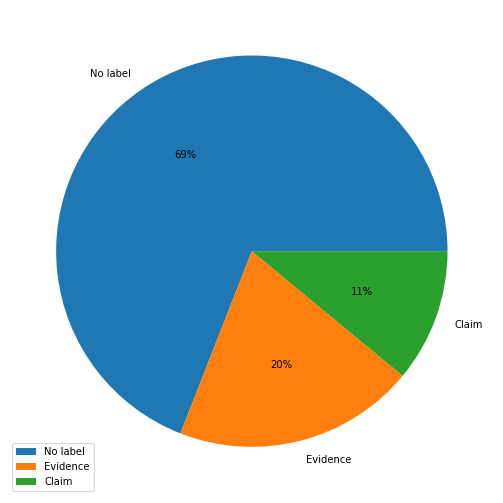

In [8]:
import matplotlib.pyplot as plt

names = ['No label', 'Evidence', 'Claim']
plt.subplots(figsize =(16, 9))
plt.pie(merged_data.label.value_counts(), labels = names, autopct='%1.0f%%')
plt.legend()

In [9]:
round(merged_data.label.value_counts() / len(merged_data) * 100, 2)

0    69.05
1    19.95
2    11.00
Name: label, dtype: float64

* We observe that we almost 70% of our sentences have no label so it is going to make our classifier predict it with higher probability since we have imbalanced dataset


* Now let's check for missing values

In [10]:
merged_data.isna().sum()

doc_id      0
sentence    0
label       0
dtype: int64

* we have no Na's in our dataset so we can proceed.


* Now let's see if we have any duplicate rows.

In [11]:
merged_data['sentence'].duplicated().any()

True

* We have duplicates so let's remove them.

In [12]:
print('Shape before removing duplicates: ', merged_data.shape)
a = merged_data.shape[0]
merged_data.drop_duplicates(subset=['sentence'], inplace=True)
print('Shape after removing duplicates: ', merged_data.shape)
print('Rows Removed: ', a - merged_data.shape[0])

merged_data.reset_index(drop=True, inplace = True)

Shape before removing duplicates:  (31093, 3)
Shape after removing duplicates:  (30862, 3)
Rows Removed:  231


* Labels Distribution

<BarContainer object of 3 artists>

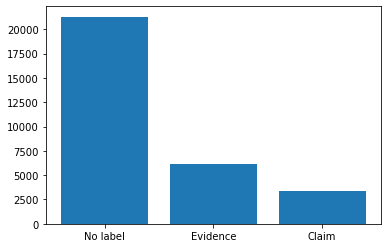

In [13]:
import matplotlib.pyplot as plt
names = ['No label', 'Evidence', 'Claim']
plt.bar(names, merged_data.label.value_counts())

# Data preprocessing

* Let's assign our X and y

In [14]:
X = merged_data['sentence']
y = merged_data['label']

* Tokenize and remove stopwords

In [15]:
from nltk import word_tokenize
from nltk.corpus import stopwords
import nltk

tokens = [word_tokenize(sentence) for sentence in X]

stopwords = stopwords.words('english')
print(stopwords[:10])

no_stops = [word for word in tokens if word not in stopwords]
no_stops[:2]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


[['Concordance',
  'Between',
  'Different',
  'Amyloid',
  'Immunoassays',
  'and',
  'Visual',
  'Amyloid',
  'Positron',
  'Emission',
  'Tomographic',
  'Assessment'],
 ['Importance',
  'Visual',
  'assessment',
  'of',
  'amyloid',
  'positron',
  'emission',
  'tomographic',
  '(',
  'PET',
  ')',
  'images',
  'has',
  'been',
  'approved',
  'by',
  'regulatory',
  'authorities',
  'for',
  'clinical',
  'use',
  '.']]

* Lemmatization

In [16]:
lemmatizer = nltk.stem.WordNetLemmatizer()

lemmatized_words = []
for i in range(len(no_stops)):
    lemmatized_words.append([lemmatizer.lemmatize(w) for w in no_stops[i]])

lemmatized_words

[['Concordance',
  'Between',
  'Different',
  'Amyloid',
  'Immunoassays',
  'and',
  'Visual',
  'Amyloid',
  'Positron',
  'Emission',
  'Tomographic',
  'Assessment'],
 ['Importance',
  'Visual',
  'assessment',
  'of',
  'amyloid',
  'positron',
  'emission',
  'tomographic',
  '(',
  'PET',
  ')',
  'image',
  'ha',
  'been',
  'approved',
  'by',
  'regulatory',
  'authority',
  'for',
  'clinical',
  'use',
  '.'],
 ['Several',
  'immunoassay',
  'have',
  'been',
  'developed',
  'to',
  'measure',
  'β-amyloid',
  '(',
  'Aβ',
  ')',
  '42',
  'in',
  'cerebrospinal',
  'fluid',
  '(',
  'CSF',
  ')',
  '.'],
 ['The',
  'agreement',
  'between',
  'CSF',
  'Aβ42',
  'measure',
  'from',
  'different',
  'immunoassay',
  'and',
  'visual',
  'PET',
  'reading',
  'may',
  'influence',
  'the',
  'use',
  'of',
  'CSF',
  'biomarkers',
  'and/or',
  'amyloid',
  'PET',
  'assessment',
  'in',
  'clinical',
  'practice',
  'and',
  'trial',
  '.'],
 ['Objective',
  'To',
  'dete

In [17]:
for i in range(len(lemmatized_words)):
    X[i] = ' '.join(lemmatized_words[i])

* Create a function to clean our dataset

In [18]:
import re

def clean_text(text):
    """
    Pre process and convert texts to a list of words
    :param text:
    :return:
    """

    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " ", text)
    text = re.sub(r"\=", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    return text

* Let's have a look at a sentence before cleaning

In [19]:
X[107]

'This result is achieved through novel cross-link agent made by boron- and fluorine-containing heterocycle that can react between themselves upon UV- and white-light exposure .'

* Apply the clean function we created to clean our text

In [20]:
X = pd.DataFrame(X)
X['sentence']=X['sentence'].apply(clean_text)

* Let's have a look again at our X before proceeding.

In [21]:
X['sentence'][107]

'this result is achieved through novel cross link agent made by boron and fluorine containing heterocycle that can react between themselves upon uv and white light exposure '

### Splitting Dataset Procedure


* We split the dataset to 80% train and 20% test.
* We use a random state in order to split the same every time we run the code.
* We use stratification in order to have equal representation of all labels in both datasets.

In [22]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X['sentence'],
                                                    y,
                                                    test_size=0.20,
                                                    random_state=42,
                                                    stratify=y)

In [23]:
print(round(y_train.value_counts() / len(y_train) * 100, 2))
round(y_test.value_counts() / len(y_test) * 100, 2)

0    68.97
1    20.00
2    11.03
Name: label, dtype: float64


0    68.98
1    19.99
2    11.03
Name: label, dtype: float64

* We observe that the stratification was successful so let's proceed.


* Let's create a dataframe with the senteces and their corresponding labels of our train dataset.

In [24]:
df = pd.DataFrame(x_train)
df.columns = ['sentence']
df["label"] = y_train
df['sentence'] = df.sentence.str.strip()
df.head(5)

,sentence,label
30013,patients who failed previous monotherapy remai...,1
14079,introduction pediatric road traffic injury rem...,0
1548,here we report the rationalization of the high...,0
24046,similar result were found for low dose radioio...,1
28067,large scale clinical trial have shown that inc...,1


# Feed Forwards Network Using Keras Tokenizer & max words

* Create our tokenizer, fit it on our train dataset and convert our train and test datasets to sequences using our tokenizer.

In [25]:
from tensorflow.python.keras.preprocessing.text import Tokenizer

max_words = 10_000  # We will only consider the 10K most used words in this dataset

# Setting up Keras tokenizer
abstracts_tokenizer = Tokenizer(num_words=max_words, lower=True, oov_token='<OOV>')

# Fitting the tokenizer on the train dataset only
abstracts_tokenizer.fit_on_texts(x_train)  # Generate tokens by counting frequency

# convert our train dataset to sequences
X_train = abstracts_tokenizer.texts_to_sequences(x_train)

# convert our test dataset to sequences as well
X_test = abstracts_tokenizer.texts_to_sequences(x_test)

* Let's see the 1st row of our sequences

In [26]:
print(X_train[0])
X_test[0]

[208, 106, 2227, 575, 1373, 1040, 15, 107, 699, 189, 4396, 6, 397]


[2695, 1534, 4, 6358, 1, 124, 1905, 30]

In [27]:
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences', end='\n\n')

print('Classes: ')
print(sorted(set(y_train)))

# print the number of total distinct classes
nb_classes = np.max(y_train) + 1

print(nb_classes, 'classes')

24689 train sequences
6173 test sequences

Classes: 
[0, 1, 2]
3 classes


### Convert Sequential Data (X) to One-Hot Vectors

In [28]:
tokenizer = Tokenizer(num_words=max_words)

# Each feature set is a multi-hot vector  
X_train = tokenizer.sequences_to_matrix(X_train, 
                                        mode='binary')

print('X_train shape:', X_train.shape)
print('X_train example:', end='\n\n')

print(X_train[0])

X_train shape: (24689, 10000)
X_train example:

[0. 0. 0. ... 0. 0. 0.]


In [29]:
X_test = tokenizer.sequences_to_matrix(X_test,
                                       mode='binary')

print('X_test shape:', X_test.shape)
print('X_test example:', end='\n\n')

print(X_test[0])

X_test shape: (6173, 10000)
X_test example:

[0. 1. 0. ... 0. 0. 0.]


### Labels Encoding

In [30]:
from tensorflow.keras.utils import to_categorical

print('Convert class vector to binary class matrix (for use with categorical_crossentropy)')

# to_categorical() function converts the labels to one_hot_encoding
Y_train = to_categorical(y_train, nb_classes)

Y_test = to_categorical(y_test, nb_classes)

print('Y_train shape:', Y_train.shape)

print('Y_test shape:', Y_test.shape)

Convert class vector to binary class matrix (for use with categorical_crossentropy)
Y_train shape: (24689, 3)
Y_test shape: (6173, 3)


# Model Build and Fit

In [31]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)   #the class weights are calculated

class_weights

C:\Users\thanp\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=30013    1
14079    0
1548     0
24046    1
28067    1
        ..
14221    1
18416    1
21237    0
11864    0
7112     0
Name: label, Length: 24689, dtype: object as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


array([0.48330201, 1.66693674, 3.02116985])

In [32]:
# Some parameters that we will use:

# define the batch size
batch_size = 32

# define number of epochs
nb_epoch = 20

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization

# define an empty sequential structure 
MLP_model = Sequential()

# add a dense layer (MLP)  (512 neurons)
MLP_model.add(Dense(512, input_shape=(max_words,)))
#Add a Batch Normalization
MLP_model.add(BatchNormalization())
# use a relu activation on MLP's outputs
MLP_model.add(Activation('relu'))
# use a dropout layer with with 50% of inputs droped
MLP_model.add(Dropout(0.5))

# add a dense layer (MLP)  (256 neurons)
MLP_model.add(Dense(256))
# use a relu activation on MLP's outputs
MLP_model.add(Activation('relu'))
#Add a Batch Normalization
MLP_model.add(BatchNormalization())
# use a dropout layer with with 50% of inputs droped
MLP_model.add(Dropout(0.5))

# add a dense layer (MLP) 
MLP_model.add(Dense(nb_classes))
#Add a Batch Normalization
MLP_model.add(BatchNormalization())
# use a softmax activation on 3nd MLP's outputs
MLP_model.add(Activation('softmax'))

# print model layers' info
print(MLP_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               5120512   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1

### Compiling the model

In [34]:
from tensorflow.keras import metrics

# we compile the model 
# using categorical crossentropy as a loss function
# and stochastic gradient descend as an optimizer
# Finally we measure Mean Absolute Error and Accuracy metrics
MLP_model.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=[
        metrics.mae,
        metrics.categorical_accuracy
    ],
)

* Create our callbacks

In [35]:
from tensorflow.python.keras.callbacks import EarlyStopping

monitor = 'val_loss'

model_fname = 'MLP_model.h5'

callbacks = [
    
    # Stop training when a monitored quantity has stopped improving.
    EarlyStopping(monitor=monitor,
                  patience=5,
                  verbose=1, #it is used to count from 1 to 5
                  restore_best_weights=True), #It is used to keep the weights of the last epoch we had a decrease
                                              #in validation loss

]

### Model Fit

In [36]:
# We train our model
history = MLP_model.fit(
    X_train,                      # features
    Y_train,                      # labels
    epochs=nb_epoch,              # numbers of epochs
    batch_size=batch_size,        # define batch size
    verbose=1,                    # the most extended verbose
    validation_split=0.1,
    callbacks=callbacks,          
    class_weight={0:0.48330201 , 1: 1.66693674, 2:3.02116985}
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/20
695/695 [==============================] - 22s 29ms/step - loss: 0.9282 - mean_absolute_error: 0.3724 - categorical_accuracy: 0.5422 - val_loss: 0.8379 - val_mean_absolute_error: 0.3453 - val_categorical_accuracy: 0.6626
Epoch 2/20
695/695 [==============================] - 22s 31ms/step - loss: 0.7663 - mean_absolute_error: 0.3282 - categorical_accuracy: 0.6502 - val_loss: 0.7742 - val_mean_absolute_error: 0.3117 - val_categorical_accuracy: 0.6889
Epoch 3/20
695/695 [==============================] - 21s 30ms/step - loss: 0.6898 - mean_absolute_error: 0.2982 - categorical_accuracy: 0.6961 - val_loss: 0.6995 - val_mean_absolute_error: 0.2796 - val_categorical_accuracy: 0.7201
Epoch 4/20
695/695 [==============================] - 22s 31ms/step - loss: 0.6271 - mean_absolute_error: 0.2734 - categorical_accuracy: 0.7229 - val_loss: 0.6710 - v

* Plot the history of our fitted model

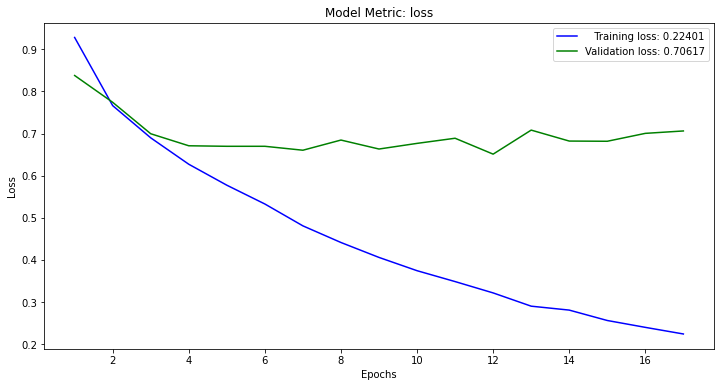

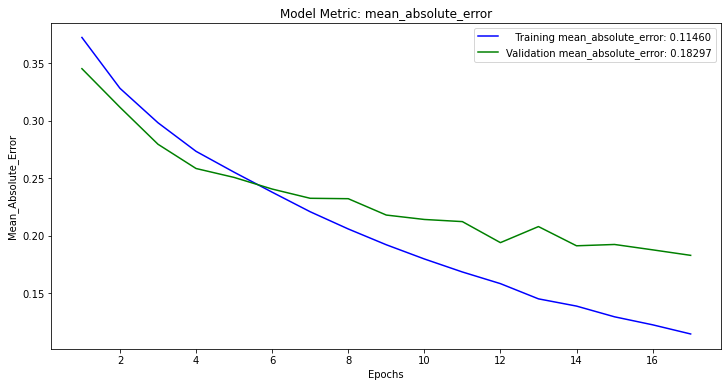

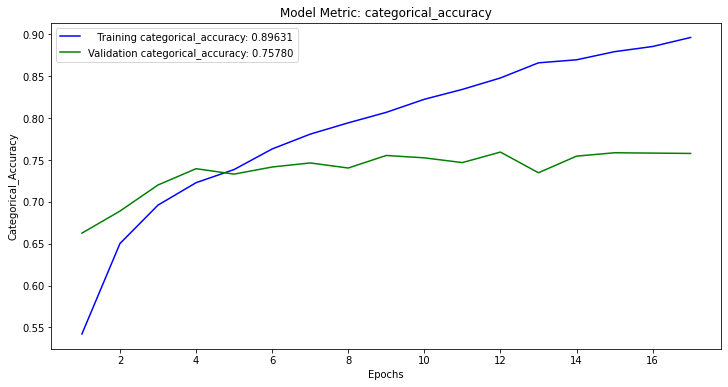

In [37]:
import matplotlib.pyplot as plt

%matplotlib inline

def plot_keras_history(history):
    """
    
    :param history: 
    :return: 
    """
    # the history object gives the metrics keys. 
    # we will store the metrics keys that are from the training sesion.
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        # getting the training values
        metric_train_values = history.history.get(metric, [])
        
        # getting the validation values
        metric_val_values = history.history.get("val_{}".format(metric), [])

        # As loss always exists as a metric we use it to find the 
        epochs = range(1, len(metric_train_values) + 1)
        
        # leaving extra spaces to allign with the validation text
        training_text = "   Training {}: {:.5f}".format(metric,
                                                        metric_train_values[-1])

        # metric
        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_train_values,
                 'b',
                 label=training_text)
        
        # if we validation metric exists, then plot that as well
        if metric_val_values:
            validation_text = "Validation {}: {:.5f}".format(metric,
                                                             metric_val_values[-1])

            plt.plot(epochs,
                     metric_val_values,
                     'g',
                     label=validation_text)
        
        # add title, xlabel, ylabe, and legend
        plt.title('Model Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()
    
plot_keras_history(history)

* Save the weights of our model

In [60]:
MLP_model.save_weights('MLP_Weights.h5')

### Model Evaluation

In [39]:
# evaluate and store on score variable on the TEST DATASET
score = MLP_model.evaluate(
    X_test,                  # features
    Y_test,                  # labels
    batch_size=batch_size,   # batch size
    verbose=1                # the most extended verbose
)

print('\nTest categorical_crossentropy:', score[0])
print('\nTest mean_absolute_error:', score[1])
print('\nTest accuracy: {:.3f} %'.format(score[2]*100))

193/193 [==============================] - 1s 7ms/step - loss: 0.6195 - mean_absolute_error: 0.1904 - categorical_accuracy: 0.7679

Test categorical_crossentropy: 0.6194664835929871

Test mean_absolute_error: 0.1904105693101883

Test accuracy: 76.786 %


* Confusion matrix of our model

In [40]:
from itertools import cycle
from typing import List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interp
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

def print_confusion_matrix(y_true,
                           y_pred,
                           class_names: List[str],
                           figsize: Tuple[int, int] = (10, 7),
                           fontsize: int = 14) -> pd.DataFrame:
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heat-map.

    For something more extraordinary check this repo:
    https://github.com/wcipriano/pretty-print-confusion-matrix


    :param class_names:  An ordered list of class names
    :param figsize: A 2-long tuple, the first value determining the horizontal size of the outputted
                    figure, the second determining the vertical size. Defaults to (10,7).
    :param fontsize: Font size for axes labels. Defaults to 14.
    :return: The confusion matrix as a dataset
    """
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

    df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

    fig = plt.figure(figsize=figsize)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    except ValueError:

        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                                 rotation=0,
                                 ha='right',
                                 fontsize=fontsize)

    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                                 rotation=45,
                                 ha='right',
                                 fontsize=fontsize)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return df_cm

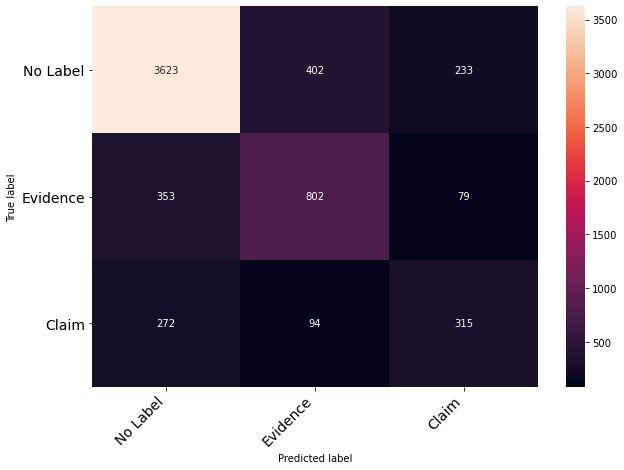

,No Label,Evidence,Claim
No Label,3623,402,233
Evidence,353,802,79
Claim,272,94,315


In [41]:
y_test_normal = np.array(y_test).astype('int64')
y_pred_class = np.argmax(MLP_model.predict(X_test), axis=-1)
class_names = ('No Label', 'Evidence', 'Claim')

print_confusion_matrix(y_true=y_test_normal,
                       y_pred=y_pred_class,
                       class_names=class_names)

* classification report of our model

In [42]:
from sklearn.metrics import classification_report

print(classification_report(y_test_normal, y_pred_class))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4258
           1       0.62      0.65      0.63      1234
           2       0.50      0.46      0.48       681

    accuracy                           0.77      6173
   macro avg       0.66      0.65      0.66      6173
weighted avg       0.77      0.77      0.77      6173



# CNN

### Padding

In [43]:
from tensorflow.python.keras.preprocessing.text import Tokenizer

# convert our train dataset to sequences
x_train = abstracts_tokenizer.texts_to_sequences(x_train)

# convert our test dataset to sequences as well
x_test = abstracts_tokenizer.texts_to_sequences(x_test)

In [44]:
count = []
for listElem in x_train:
    count.append(len(listElem))

maxlen = int(np.percentile(count, q=90))
maxlen

38

In [45]:
from tensorflow.python.keras.preprocessing import sequence

x_train = sequence.pad_sequences(x_train,
                                 maxlen=maxlen,
                                 padding='pre', #apply padding at the start of the sentece
                                 truncating='pre', #keep only the last 38 words of the sentence
                                 value=0.0)

x_test = sequence.pad_sequences(x_test,
                                maxlen=maxlen,
                                 padding='pre',
                                 truncating='pre',
                                 value=0.0)

In [46]:
print('x_train shape: {}'.format(x_train.shape))
print('x_test shape: {}'.format(x_test.shape))

x_train shape: (24689, 38)
x_test shape: (6173, 38)


In [47]:
# checking again the first sentence with the padding.
print(x_train[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0  208  106 2227
  575 1373 1040   15  107  699  189 4396    6  397]


In [48]:
# network hyperparameters
embedding_dims = 50  #each word is represented by a vector of length 50

nof_filters = 25 #Number of filters that will be applied during the convolution

kernel_size = 3 #3 read 3 sentences in each step, like a trigram

hidden_dims = 50 #neurons of a hidden layer

## Build Model

In [50]:
from tensorflow.python.keras.models import Sequential

from tensorflow.python.keras.layers import Dense, Dropout, Activation
from tensorflow.python.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D

print('Build model...')

CNN_model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
CNN_model.add(Embedding(max_words,
                    embedding_dims,
                    input_length=maxlen))

CNN_model.add(Dropout(0.5))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:

CNN_model.add(Conv1D(nof_filters, 
                 kernel_size,     #size of each filter
                 padding='valid', #we want it to not apply padding
                 activation='relu',
                 strides=1))      #pass 1 sentence in each step of the convolution

CNN_model.add(GlobalMaxPooling1D())

CNN_model.add(Dense(hidden_dims))
CNN_model.add(Dropout(0.5))
CNN_model.add(Activation('relu'))

CNN_model.add(Dense(nb_classes))
CNN_model.add(Activation('softmax'))

CNN_model.summary()

Build model...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 38, 50)            500000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 38, 50)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 36, 25)            3775      
_________________________________________________________________
global_max_pooling1d (Global (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                1300      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
activation_3 (Activation)    (None, 50)

* Model compilation

In [51]:
CNN_model.compile(
    loss='sparse_categorical_crossentropy', #sparse cause we got sparse matrices
    optimizer='adam',
    metrics=['accuracy'])

In [52]:
# fit hyperparameters
batch_size = 128
epochs = 100

* convert our labels to the format we want 

In [53]:
Y_train = to_categorical(Y_train, nb_classes)
y_train = np.array(y_train).astype('int64')
y_train

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [54]:
Y_test = to_categorical(Y_test, nb_classes)
y_test = np.array(y_test).astype('int64')
y_test

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

* Fir our model

In [55]:
history = CNN_model.fit(
    x_train,                # features
    y_train,                # labels
    epochs=epochs,          # numbers of epoch
    batch_size=batch_size,  # define batch size
    verbose=2,              # the most extended verbose
    validation_split = 0.1,   # 90% for train and 10% for validation
    callbacks=[callbacks],
    class_weight={0:0.48330201 , 1: 1.66693674, 2:3.02116985}
)

Epoch 1/100
174/174 - 3s - loss: 1.0543 - accuracy: 0.3912 - val_loss: 0.9620 - val_accuracy: 0.5889
Epoch 2/100
174/174 - 3s - loss: 0.8403 - accuracy: 0.6128 - val_loss: 0.7429 - val_accuracy: 0.6938
Epoch 3/100
174/174 - 2s - loss: 0.6870 - accuracy: 0.7117 - val_loss: 0.6762 - val_accuracy: 0.7258
Epoch 4/100
174/174 - 2s - loss: 0.6091 - accuracy: 0.7463 - val_loss: 0.6508 - val_accuracy: 0.7303
Epoch 5/100
174/174 - 2s - loss: 0.5413 - accuracy: 0.7733 - val_loss: 0.6530 - val_accuracy: 0.7299
Epoch 6/100
174/174 - 2s - loss: 0.4811 - accuracy: 0.7940 - val_loss: 0.6500 - val_accuracy: 0.7432
Epoch 7/100
174/174 - 2s - loss: 0.4311 - accuracy: 0.8171 - val_loss: 0.6855 - val_accuracy: 0.7363
Epoch 8/100
174/174 - 2s - loss: 0.3837 - accuracy: 0.8302 - val_loss: 0.7105 - val_accuracy: 0.7355
Epoch 9/100
174/174 - 2s - loss: 0.3556 - accuracy: 0.8450 - val_loss: 0.7297 - val_accuracy: 0.7408
Epoch 10/100
174/174 - 2s - loss: 0.3246 - accuracy: 0.8567 - val_loss: 0.7967 - val_accura

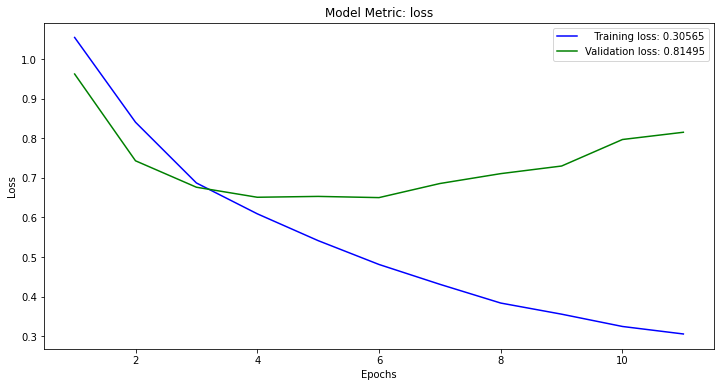

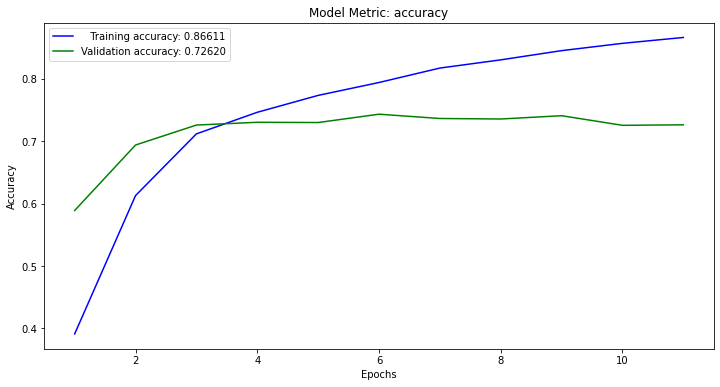

In [56]:
plot_keras_history(history)

In [61]:
CNN_model.save_weights('CNN_Weights.h5')

In [57]:
score = CNN_model.evaluate(
    x_test,                  # features
    y_test,                  # labels
    batch_size=batch_size,   # batch size
    verbose=1                # the most extended verbose
)


print('\nTest categorical_crossentropy:', score[0])
print('\nTest accuracy:', score[1])

49/49 [==============================] - 0s 2ms/step - loss: 0.6361 - accuracy: 0.7450

Test categorical_crossentropy: 0.6361156702041626

Test accuracy: 0.7450186014175415


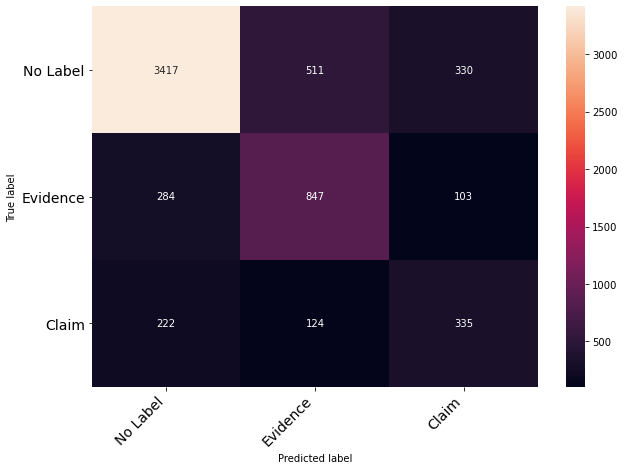

,No Label,Evidence,Claim
No Label,3417,511,330
Evidence,284,847,103
Claim,222,124,335


In [58]:
y_test_normal =y_test
y_pred_class = np.argmax(CNN_model.predict(x_test), axis=-1)
class_names = ('No Label', 'Evidence', 'Claim')

print_confusion_matrix(y_true=y_test_normal,
                       y_pred=y_pred_class,
                       class_names=class_names)

In [59]:
from sklearn.metrics import classification_report

print(classification_report(y_test_normal, y_pred_class))

              precision    recall  f1-score   support

           0       0.87      0.80      0.84      4258
           1       0.57      0.69      0.62      1234
           2       0.44      0.49      0.46       681

    accuracy                           0.75      6173
   macro avg       0.63      0.66      0.64      6173
weighted avg       0.76      0.75      0.75      6173

